In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crypto/binance-coin_2018-03-06_2023-03-05.csv


In [2]:
import pandas as pd
import keras
from datetime import datetime
import matplotlib.pyplot as plt

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from keras.layers import Input, LSTM, Dense, TimeDistributed, Activation, BatchNormalization, Dropout, Bidirectional
from keras.models import Sequential
from keras.utils import Sequence
from keras.layers import CuDNNLSTM


In [3]:
df = pd.read_csv('/kaggle/input/crypto/binance-coin_2018-03-06_2023-03-05.csv')

In [4]:
df

,Date,Open,High,Low,Close,Volume,Market Cap
0,Mar-03-2023,290.578300,291.656451,287.288000,289.933827,8.864673e+08,4.647844e+10
1,Mar-02-2023,300.322500,300.554300,288.026200,290.413337,1.312458e+09,4.651630e+10
2,Mar-01-2023,303.262000,304.045000,296.833200,300.226000,1.091921e+09,4.793647e+10
3,Feb-28-2023,301.874550,306.442800,301.284893,303.493500,1.081014e+09,4.855769e+10
4,Feb-27-2023,305.127542,305.913700,300.981365,302.036278,1.132201e+09,4.858260e+10
...,...,...,...,...,...,...,...
1820,Mar-09-2018,8.393523,8.394454,7.697779,7.741142,2.886964e+07,0.000000e+00
1821,Mar-08-2018,8.340532,8.374791,7.193116,8.374791,3.573931e+07,0.000000e+00
1822,Mar-07-2018,9.119737,9.195546,8.239773,8.371564,4.598669e+07,0.000000e+00
1823,Mar-06-2018,9.402097,10.195821,8.361776,9.101921,3.692032e+07,0.000000e+00


In [5]:
df = df[['Date', 'Close']]
df.head()

,Date,Close
0,Mar-03-2023,289.933827
1,Mar-02-2023,290.413337
2,Mar-01-2023,300.226000
3,Feb-28-2023,303.493500
4,Feb-27-2023,302.036278


In [6]:
df.dtypes

Date      object
Close    float64
dtype: object

In [7]:
month_dict = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04',
              'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08',
              'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}
df = df.replace({'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04',
              'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08',
              'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}, regex = True)

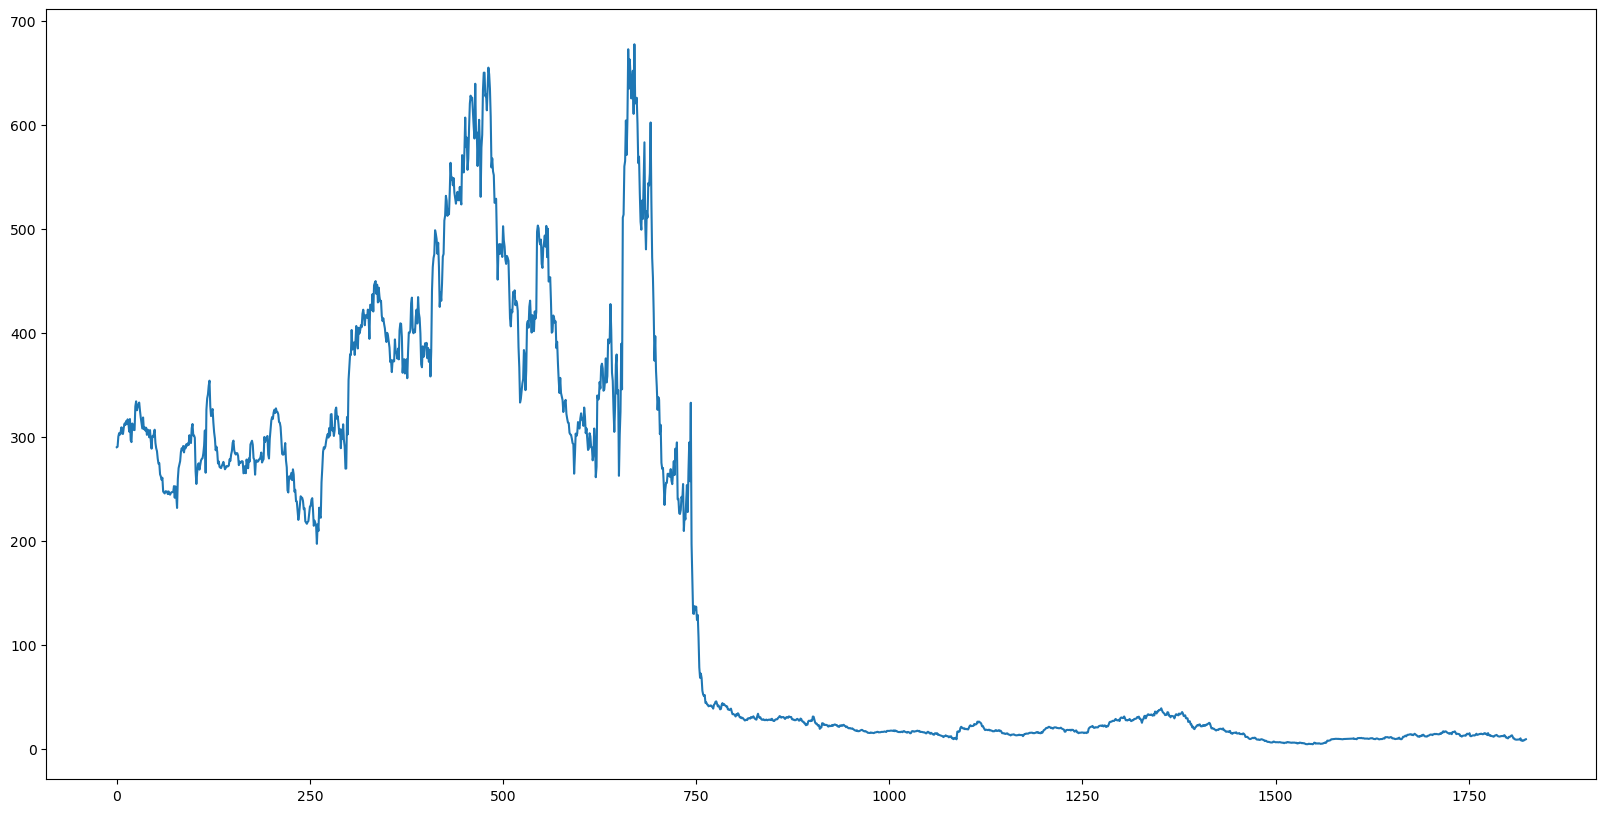

In [8]:
plt.plot(df["Close"],label='Close Price history')

In [9]:
df.describe(include='all')

,Date,Close
count,1825,1825.000000
unique,1825,NaN
top,03-03-2023,NaN
freq,1,NaN
mean,NaN,161.066151
std,NaN,184.049905
min,NaN,4.512925
25%,NaN,15.547068
50%,NaN,29.180330
75%,NaN,303.850000


In [10]:
df['Date'] = pd.to_datetime(df['Date'])

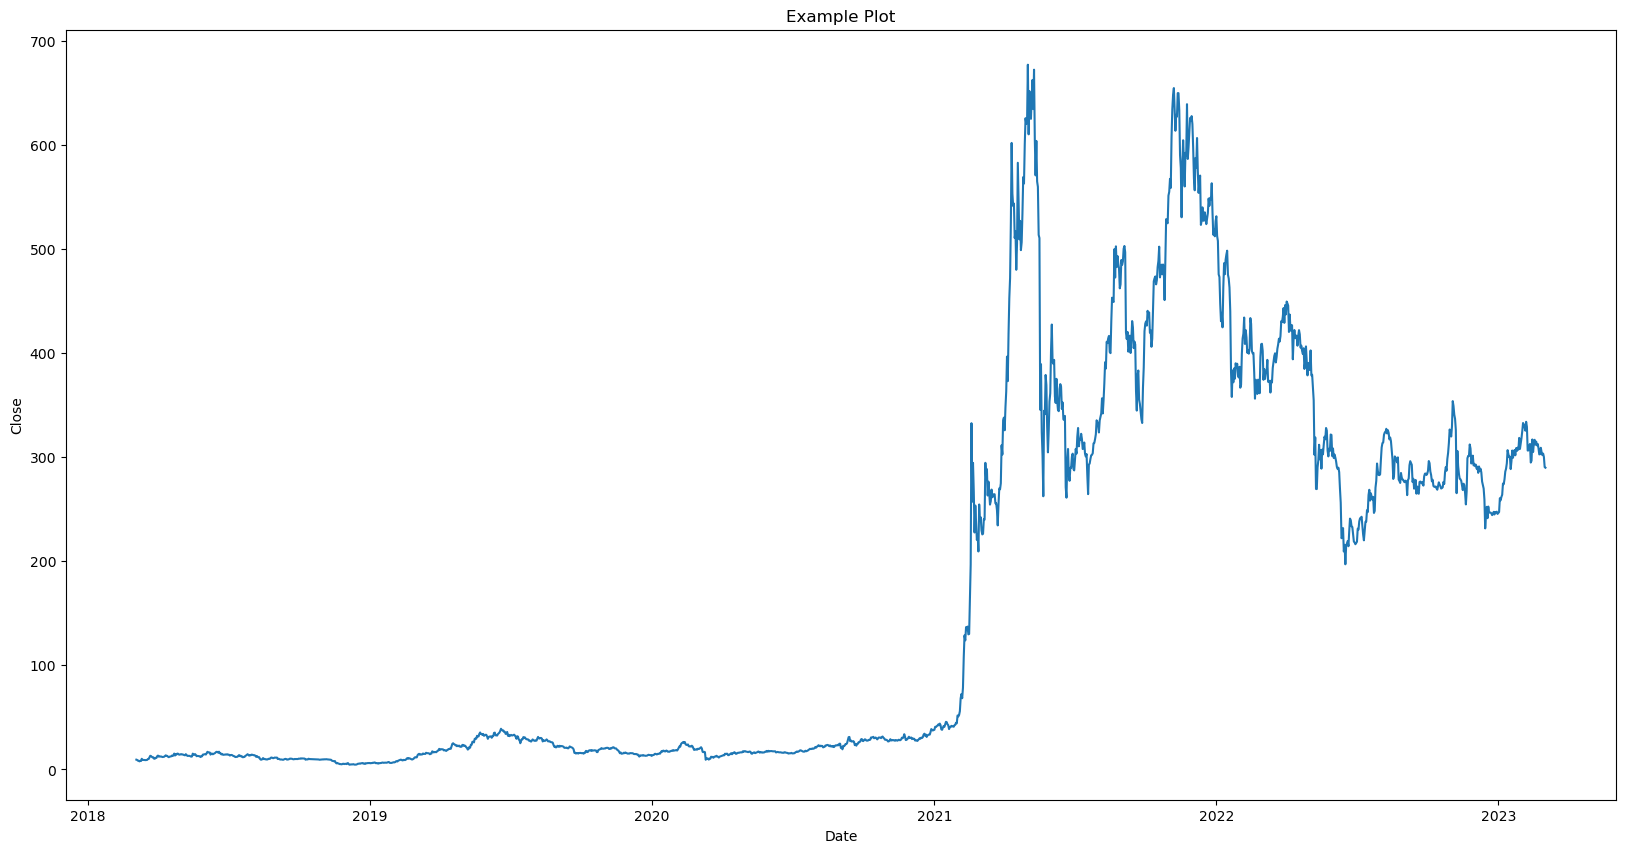

In [11]:
plt.plot(df['Date'], df['Close'])
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Example Plot')
plt.show()

In [12]:

scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [13]:
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

In [14]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [15]:
X_train.shape

(1638, 99, 1)

In [16]:
X_test.shape

(87, 99, 1)

In [17]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

In [18]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)